# 1. Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 2. Utilities

In [83]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
      # just plotting multiple predictions essentially
      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    plt.show()

def trend(time, slope=0):
    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

# 3. Generate the Synthetic Data

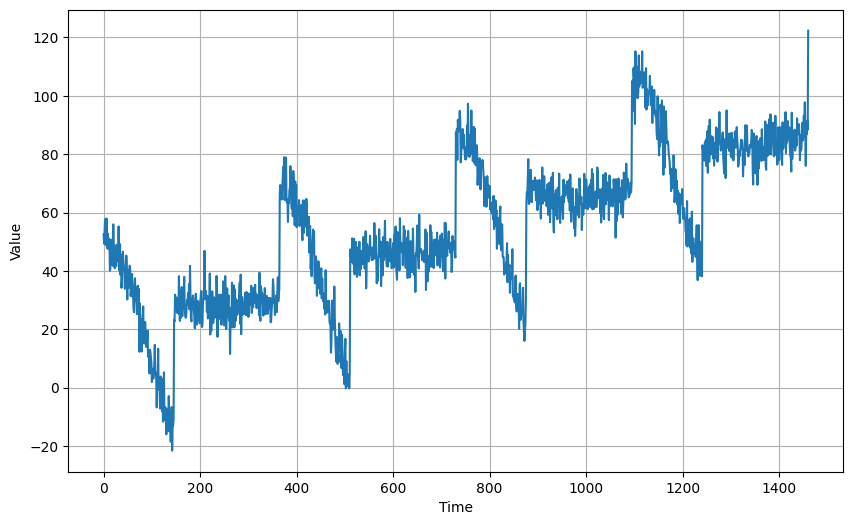

In [92]:
# Parameters
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)

# Plot the synthetic data
plot_series(time, series)

# 4. Split the Dataset

In [93]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# 5. Prepare Features and Labels

In [94]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Understanding the lines in the function below:
- The window() method returns a dataset containing windows, where each window is itself represented as a dataset. 
- Something like {{1,2,3,4,5},{6,7,8,9,10},...}, where {...} represents a dataset. 
- But we just want a regular dataset containing tensors: {[1,2,3,4,5],[6,7,8,9,10],...}, where [...] represents a tensor. 
- The flat_map() method returns all the tensors in a nested dataset, after transforming each nested dataset. 
- If we didn't batch, we would get: {1,2,3,4,5,6,7,8,9,10,...}. 
- By batching each window to its full size, we get {[1,2,3,4,5],[6,7,8,9,10],...} as we desired.

So why, still, does .window() return windows and not just a dataset of tensors?
- Tensors are n-dimensional, meaning they can have an arbitrary number of dimensions. They are not rectangular, which would be restricted to 2-dimensional.
- Datasets are an API for inputting data. If your data are in Dataset form, then you can use the various processing methods that the tf.data module provides, like parallel processing, shuffling, batching, and others. You can also match your features an labels in a single Dataset, as opposed to using two separate Tensor objects.




In [95]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    # --------------------------------------------
    # Creates a TensorFlow Dataset object where each item is a scalar tensor
    dataset = tf.data.Dataset.from_tensor_slices(series) 

    # Window the data but only take those with the specified size
    # -----------------------------------------------------------
    # Windows the data into windows of window_size + 1 elements, sliding by 1.
    # Creates a dataset of windows (can think of windows like datasets too that can be iterated over)
    # windows are essentially themselves datasets; datasets are returned because the size of sequences may vary 
    # and some individual flexibility on pre-processing 
    # and also gives flexibility to 
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    # -------------------------------------------------------------
    # Converts the dataset of windows into a single dataset
    # The argument to flat_map is a function that takes an element from the dataset and returns a Dataset. 
    # flat_map chains together the resulting datasets sequentially.
    # For example, to turn each window into a dense tensor
    # - individual tensors used here, for each sequence, to handle different tensor shapes
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of the windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [96]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 6. Build the Model

In [97]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 7. Train the Model

In [105]:
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1e-6, momentum=0.9))
model_baseline.fit(dataset, epochs=100, verbose=2)

Epoch 1/100
31/31 [==============================] - 0s 747us/step - loss: 46.1136
Epoch 2/100
31/31 [==============================] - 0s 492us/step - loss: 46.0349
Epoch 3/100
31/31 [==============================] - 0s 462us/step - loss: 45.9154
Epoch 4/100
31/31 [==============================] - 0s 442us/step - loss: 45.8085
Epoch 5/100
31/31 [==============================] - 0s 464us/step - loss: 45.8445
Epoch 6/100
31/31 [==============================] - 0s 460us/step - loss: 46.0992
Epoch 7/100
31/31 [==============================] - 0s 479us/step - loss: 46.1519
Epoch 8/100
31/31 [==============================] - 0s 674us/step - loss: 45.8022
Epoch 9/100
31/31 [==============================] - 0s 476us/step - loss: 45.8002
Epoch 10/100
31/31 [==============================] - 0s 480us/step - loss: 46.1278
Epoch 11/100
31/31 [==============================] - 0s 476us/step - loss: 45.9637
Epoch 12/100
31/31 [==============================] - 0s 457us/step - loss: 45.9725
E

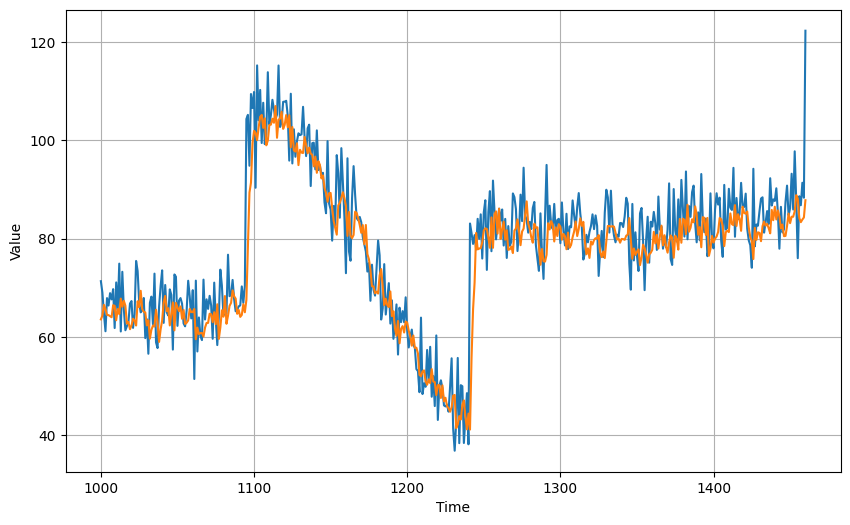

In [100]:
# Initialize a list
forecast = []

# Reduce the original series, remember we subtract window_size to get the sequence that creates the first item in validation set
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  # use of [np.newaxis] adds extra dimension to data
  # np.array([1,2,3])[np.newaxis] prints array([[1, 2, 3]])
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [106]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

48.767143
5.0744004


# 8. Tuning the Learning rate

In [107]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [108]:
"""
Defining a learning rate scheduler callback.

This will allow you to dynamically set the learning rate based on the epoch number during training. 
As shown below, you will pass a lambda function to declare the value of the learning rate. 
It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.
"""

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [109]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 846us/step - loss: 252.4705 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 463us/step - loss: 219.9855 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 468us/step - loss: 195.3696 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 526us/step - loss: 180.1928 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 441us/step - loss: 171.6143 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 448us/step - loss: 167.3330 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 456us/step - loss: 165.1102 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 452us/step - loss: 164.0264 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 460us/step - loss: 163.2732 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 454us/step - loss: 162.5775 - lr: 

(1e-08, 0.001, 0.0, 300.0)

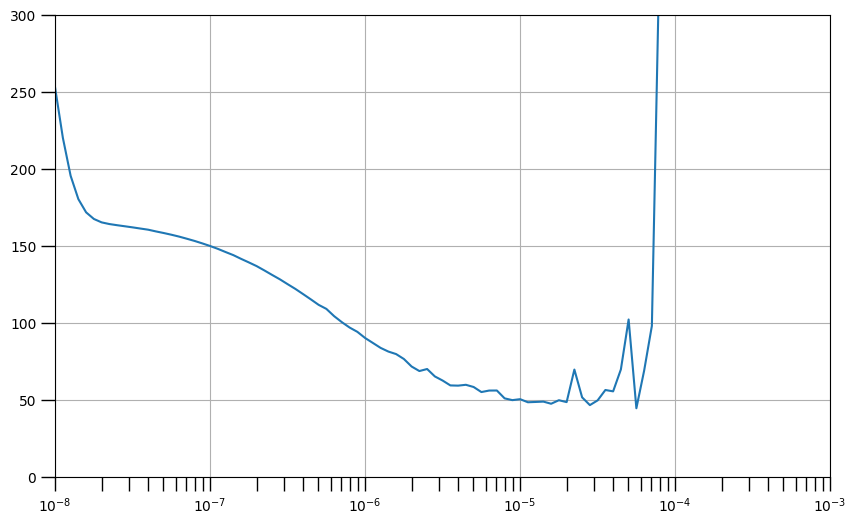

In [110]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker.

In [111]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [113]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=4e-6, momentum=0.9)

In [114]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 896us/step - loss: 711.5551
Epoch 2/100
31/31 [==============================] - 0s 460us/step - loss: 108.4943
Epoch 3/100
31/31 [==============================] - 0s 458us/step - loss: 73.4278
Epoch 4/100
31/31 [==============================] - 0s 444us/step - loss: 69.8467
Epoch 5/100
31/31 [==============================] - 0s 457us/step - loss: 67.2661
Epoch 6/100
31/31 [==============================] - 0s 462us/step - loss: 64.8097
Epoch 7/100
31/31 [==============================] - 0s 437us/step - loss: 62.1993
Epoch 8/100
31/31 [==============================] - 0s 441us/step - loss: 61.7425
Epoch 9/100
31/31 [==============================] - 0s 457us/step - loss: 62.3386
Epoch 10/100
31/31 [==============================] - 0s 452us/step - loss: 61.7959
Epoch 11/100
31/31 [==============================] - 0s 454us/step - loss: 58.2395
Epoch 12/100
31/31 [==============================] - 0s 447us/step - loss: 57.1907

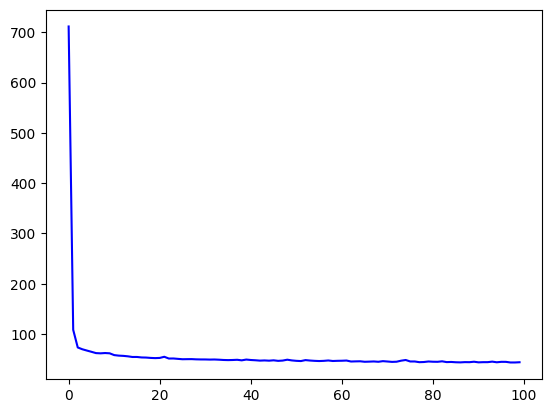

In [115]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

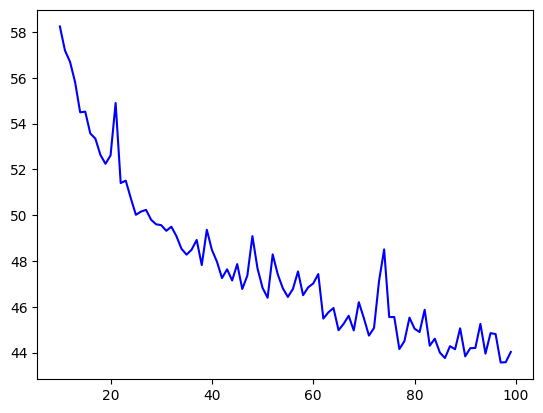

In [116]:
# Graph above looks like we are training for too long but if we zoom in a bit and ignore the large loss change in the first 10 epochs
# we can actually see the loss is continuining to go down, so we could train for longer

# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

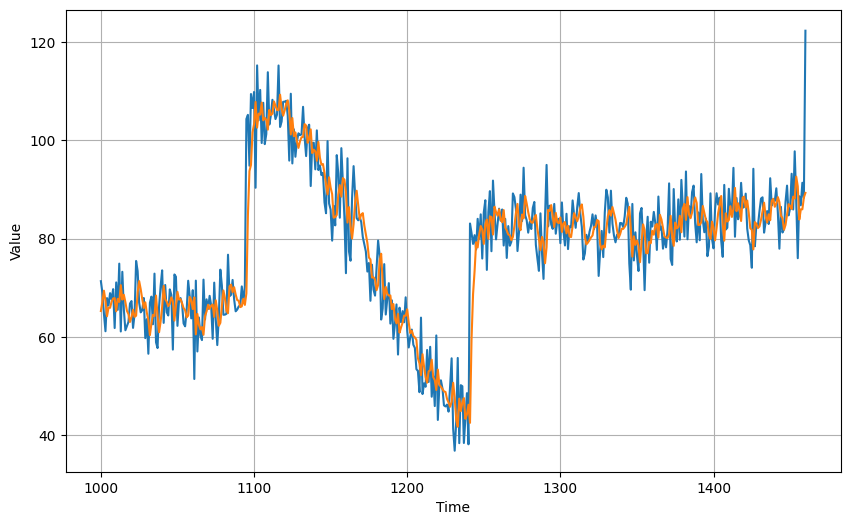

In [119]:
# Getting the predictions again:

# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [120]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

43.66182
4.879386
